# 1. Imports & Utility Functions



In [1]:
import cv2
import numpy as np
from collections import deque

def show_side_by_side(orig, edited, title="Preview"):
    if orig.shape != edited.shape:
        edited = cv2.resize(edited, (orig.shape[1], orig.shape[0]))
    combo = np.hstack((orig, edited))
    # We'll display inline instead of cv2.imshow
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.imshow(cv2.cvtColor(combo, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not load '{path}'")
    return img

def adjust_brightness(img, beta):
    return np.clip(img.astype(np.int16) + beta, 0, 255).astype(np.uint8)

def adjust_contrast(img, alpha):
    return np.clip(img.astype(np.float32) * alpha, 0, 255).astype(np.uint8)

def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

def add_padding(img, top, bottom, left, right, border_type, value=(0,0,0)):
    return cv2.copyMakeBorder(img, top, bottom, left, right,
                              borderType=border_type, value=value)

def apply_threshold(img, thresh, inv=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ttype = cv2.THRESH_BINARY_INV if inv else cv2.THRESH_BINARY
    _, bw = cv2.threshold(gray, thresh, 255, ttype)
    return cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)

def manual_blend(img1, img2, alpha):
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    f1 = img1.astype(np.float32)
    f2 = img2.astype(np.float32)
    out = ((1-alpha)*f1 + alpha*f2).clip(0,255).astype(np.uint8)
    return out


# 2. Load a Base Image

Load one sample image to work on throughout the notebook.


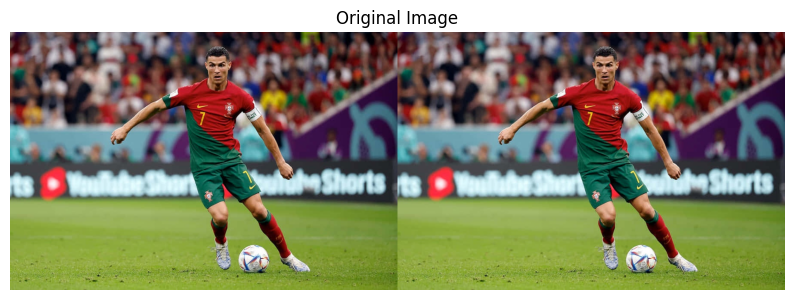

In [ ]:

img = load_image("./Image.png")
show_side_by_side(img, img, title="Original Image")


# 3. Adjust Brightness

Demonstrate `adjust_brightness()` with β = +50 (brighter) and β = –50 (darker).


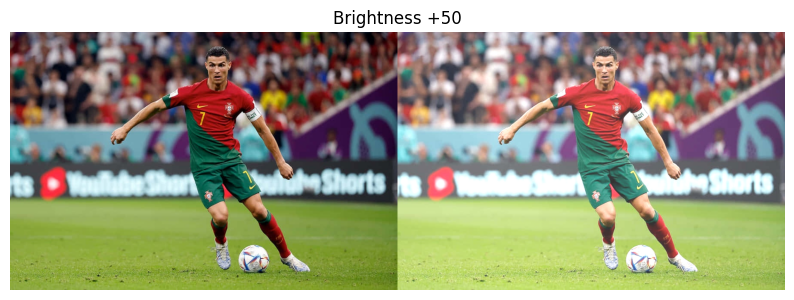

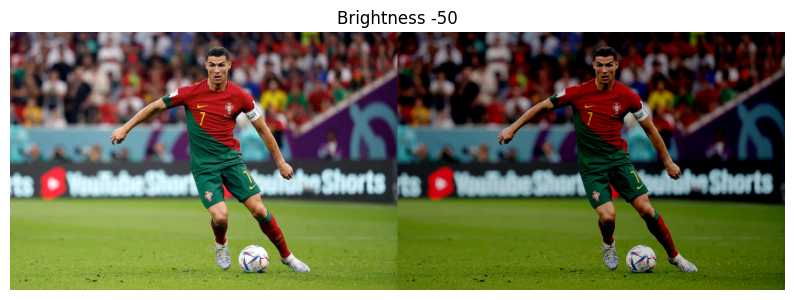

In [3]:
bright = adjust_brightness(img, 50)
dark   = adjust_brightness(img, -50)

show_side_by_side(img, bright, title="Brightness +50")
show_side_by_side(img, dark,   title="Brightness -50")


# 4. Adjust Contrast

Use α = 1.5 (higher contrast) and α = 0.5 (lower contrast).


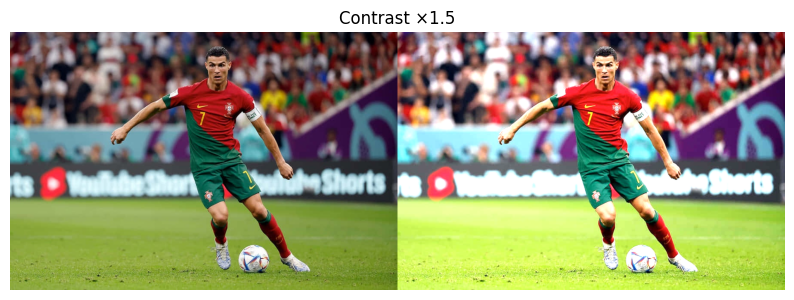

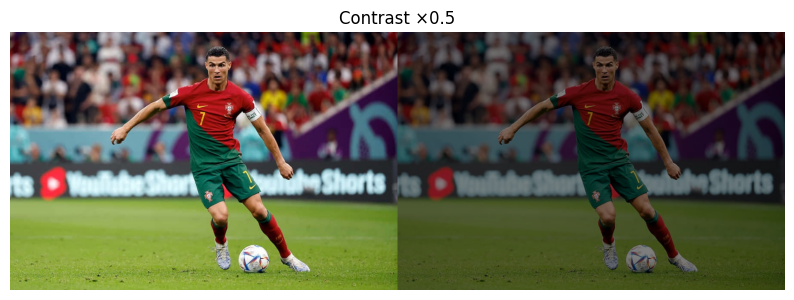

In [4]:
high_contrast = adjust_contrast(img, 1.5)
low_contrast  = adjust_contrast(img, 0.5)

show_side_by_side(img, high_contrast, title="Contrast ×1.5")
show_side_by_side(img, low_contrast,  title="Contrast ×0.5")


# 5. Convert to Grayscale

Use `to_grayscale()` to drop color.


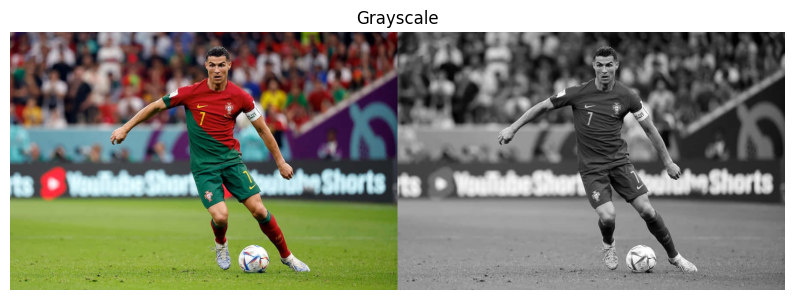

In [5]:
gray = to_grayscale(img)
show_side_by_side(img, gray, title="Grayscale")


# 6. Add Padding

Add a constant red border and a reflect border.


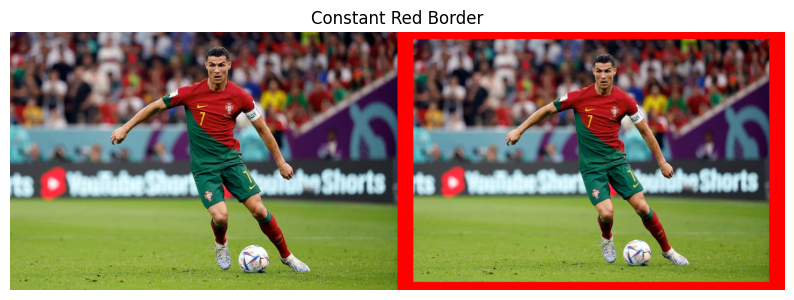

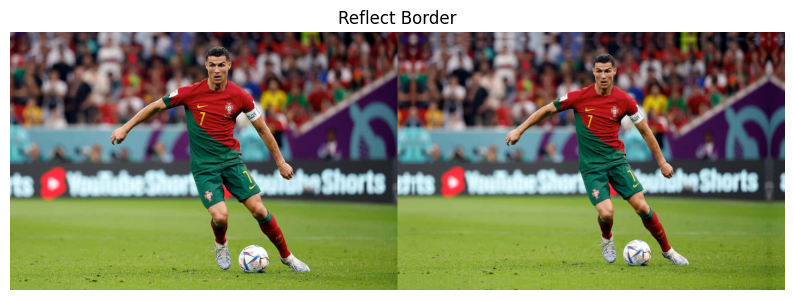

In [6]:
pad_const = add_padding(img, 20,20,40,40, cv2.BORDER_CONSTANT, value=(0,0,255))
pad_refl  = add_padding(img, 20,20,40,40, cv2.BORDER_REFLECT)

show_side_by_side(img, pad_const, title="Constant Red Border")
show_side_by_side(img, pad_refl,  title="Reflect Border")


# 7. Apply Thresholding

Binary threshold at 127, and inverted binary threshold.


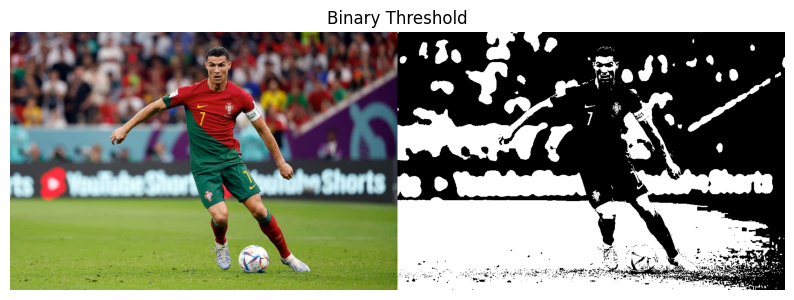

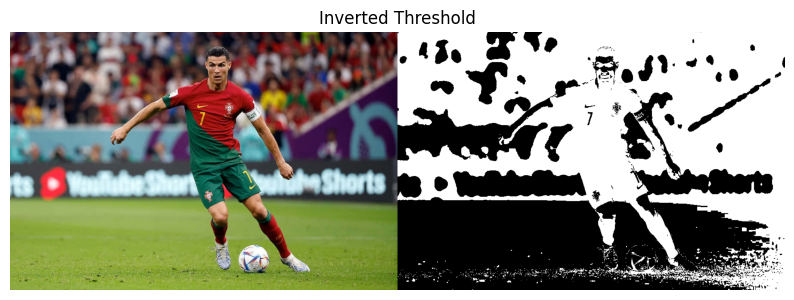

In [7]:
th_bin   = apply_threshold(img, 127, inv=False)
th_inv   = apply_threshold(img, 127, inv=True)

show_side_by_side(img, th_bin, title="Binary Threshold")
show_side_by_side(img, th_inv, title="Inverted Threshold")


# 8. Blend with Another Image

Load a second image and blend with α = 0.6.


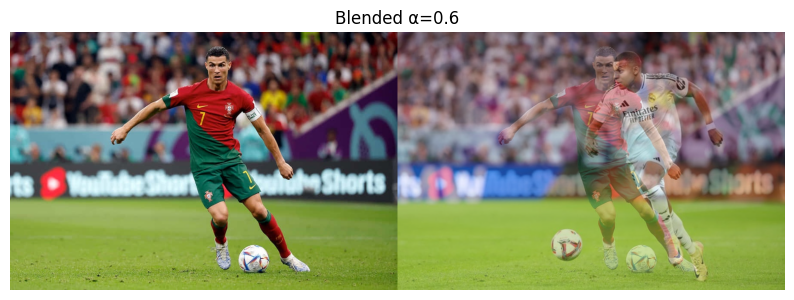

In [12]:
img2 = load_image('./Image2.jpg') 
blend = manual_blend(img, img2, 0.6)
show_side_by_side(img, blend, title="Blended α=0.6")


# 9. Simulate Undo & History

Show how `deque` and `history` track operations and how undo works.


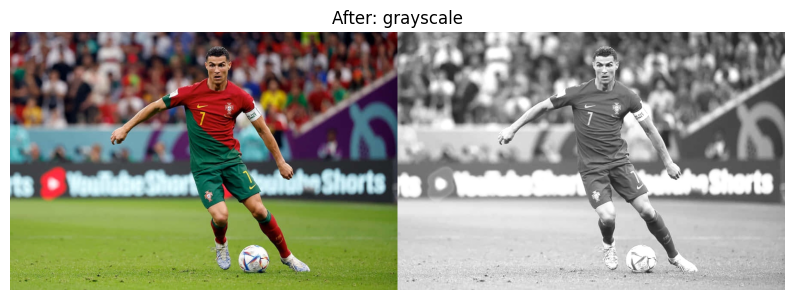

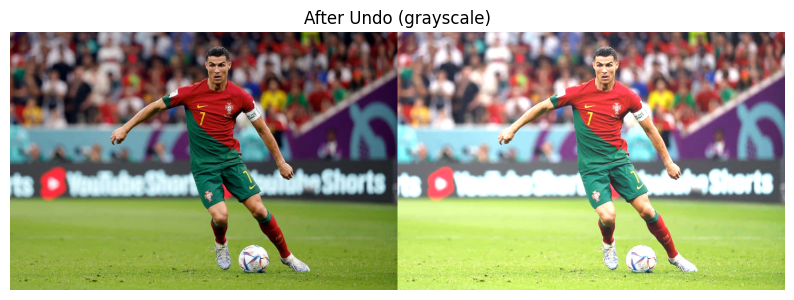

History now: ['bright +30', 'contrast ×1.2']


In [13]:
from collections import deque

stack   = deque(maxlen=10)
history = []

# initial state
stack.append(img.copy())

# perform a few ops
ops = [
    ("bright +30", lambda im: adjust_brightness(im, 30)),
    ("contrast ×1.2", lambda im: adjust_contrast(im, 1.2)),
    ("grayscale",     to_grayscale)
]

for name, fn in ops:
    next_img = fn(stack[-1])
    stack.append(next_img)
    history.append(name)

# show latest
show_side_by_side(img, stack[-1], title=f"After: {history[-1]}")

# undo last
stack.pop(); undone = history.pop()
show_side_by_side(img, stack[-1], title=f"After Undo ({undone})")
print("History now:", history)


# 10. Save Result

Write the current top‐of‐stack image to disk.


In [14]:
output = "edited_output.jpg"
cv2.imwrite(output, stack[-1])
print(f"Saved final image as: {output}")


Saved final image as: edited_output.jpg
